In [1]:
from utils import conv
from utils import NN2hidden as nn2
from utils import dataprepare as dp
from utils import Feature_extract as fe

import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
# import os
# # Load images and filenames
# train_images, train_image_filenames = dp.load_images_from_folder_filenames('rev_patching/patch_image')

# # Extract feature maps from images
# feature_maps = [fe.extract(image) for image in train_images]

# # Save feature maps with the same filenames as the original images
# for i, (feature_map, image_filename) in enumerate(zip(feature_maps, train_image_filenames)):
#     image_name = os.path.splitext(image_filename)[0]
#     pil_image = Image.fromarray(feature_map)
#     pil_image.save(f'rev_patching/feature_extract_image/{image_name}.png', format='PNG')

In [3]:
# Load images and ground truth labels
images_path = 'patching_fix/patch_image'
feature_images_path = 'patching_fix/extract_ori'
ground_truths_path = 'patching_fix/patch_ground'

images_load = dp.load_images_from_folder(images_path)
feature_images_load = dp.load_images_from_folder(feature_images_path)
ground_truths = dp.load_ground_truth_from_folder(ground_truths_path)

In [4]:
feature_images_train = feature_images_load[:math.ceil(len(feature_images_load)*0.7)] 
image_label_train = ground_truths[:math.ceil(len(ground_truths)*0.7)]

image_test = images_load[math.ceil(len(images_load)*0.7):]
image_label_test = ground_truths[math.ceil(len(ground_truths)*0.7):]

In [5]:
len(feature_images_train)

1769

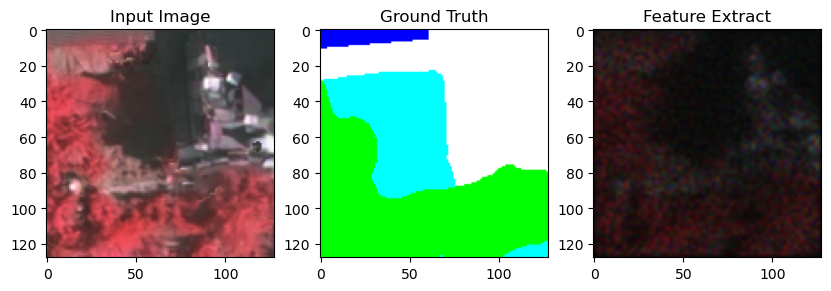

In [6]:
indeks = 1597
# Plot the images
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(images_load[indeks])
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(ground_truths[indeks])
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(feature_images_load[indeks])
plt.title('Feature Extract')

plt.show()

In [7]:
# Prepare data
X, y = dp.prepare_data(feature_images_train, image_label_train)

In [8]:
len(X)

3

In [9]:
# Normalize the features
X_normalized = X / 255.0

In [10]:
X_normalized.shape

(3, 28983296)

In [11]:
# Initialize the neural network
input_size = X_normalized.shape[0]
hidden_size1 = 3  # neuron hidden layer 1
hidden_size2 = 2  # neuron hidden layer 2
output_size = 2  # 2 classes: vegetation and non-vegetation
learning_rate = 0.001
num_epochs = 20
toleransi_error = 0.1

# Initialize the neural network with adjusted hidden size
model = nn2.NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

# Check the shape of weights_hidden_output
print(model.weights_hidden2_output.shape)

(2, 2)


In [12]:
print('Bobot dan bias sebelum training:')
print('Bobot hidden layer 1:\n', model.weights_input_hidden1)
print('Bias hidden layer 1:\n', model.bias_input_hidden1)
print('Bobot hidden layer 2:\n', model.weights_hidden1_hidden2)
print('Bias hidden layer 2:\n', model.bias_hidden1_hidden2)
print('Bobot output layer:\n', model.weights_hidden2_output)
print('Bias output layer:\n', model.bias_hidden2_output)

Bobot dan bias sebelum training:
Bobot hidden layer 1:
 [[-0.01        0.00220308  0.00837896]
 [ 0.01        0.01        0.01      ]
 [ 0.00932137 -0.01       -0.00130474]]
Bias hidden layer 1:
 [[0. 0. 0.]]
Bobot hidden layer 2:
 [[-0.00839431  0.00829369]
 [ 0.01        0.01      ]
 [-0.00053444  0.00343384]]
Bias hidden layer 2:
 [[0. 0.]]
Bobot output layer:
 [[-0.00060786 -0.00230081]
 [ 0.00465321 -0.00045001]]
Bias output layer:
 [[0. 0.]]


In [13]:
# Training loop with batching
batch_size = 128
num_batches = X_normalized.shape[1] // batch_size
losses = []
accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for i in range(num_batches):
        # Get batch data
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        X_batch = X_normalized[:, start_idx:end_idx].T
        y_batch = y[:, start_idx:end_idx].T
        
        # Forward pass
        output = model.forward(X_batch)
        
        # Compute loss
        loss = nn2.binary_cross_entropy(y_batch, output)
        epoch_loss += loss
        
        
        # Compute accuracy
        predicted_labels = np.argmax(output, axis=1)
        true_labels = np.argmax(y_batch, axis=1)
        correct_predictions += np.sum(predicted_labels == true_labels)
        total_predictions += len(true_labels)
        
        # Backpropagation
        model.backward(X_batch, y_batch, learning_rate)
    
    # Average loss for the epoch
    epoch_loss /= num_batches
    losses.append(epoch_loss)
    
    # Accuracy for the epoch
    # accuracy = correct_predictions / total_predictions
    accuracy = 1 - epoch_loss
    accuracies.append(accuracy)
    
    # Print loss
    if epoch % 1 == 0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {accuracy}')
    
    # Early stopping
    if epoch_loss < toleransi_error:
        print("Training berhenti karena error sudah kurang dari 0.1")
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {accuracy}')
        break

Epoch 1, Loss: 0.33736447892384663, Accuracy: 0.6626355210761534
Epoch 2, Loss: 0.2838046114119299, Accuracy: 0.7161953885880701
Epoch 3, Loss: 0.26408178829383844, Accuracy: 0.7359182117061616
Epoch 4, Loss: 0.2597635600158265, Accuracy: 0.7402364399841734
Epoch 5, Loss: 0.2578281396805046, Accuracy: 0.7421718603194953
Epoch 6, Loss: 0.25676950434425444, Accuracy: 0.7432304956557456
Epoch 7, Loss: 0.2560076231678879, Accuracy: 0.7439923768321122
Epoch 8, Loss: 0.25552959228751776, Accuracy: 0.7444704077124822
Epoch 9, Loss: 0.25518250500374656, Accuracy: 0.7448174949962534
Epoch 10, Loss: 0.2549993258330682, Accuracy: 0.7450006741669317
Epoch 11, Loss: 0.25490213630180636, Accuracy: 0.7450978636981936
Epoch 12, Loss: 0.25491690780974224, Accuracy: 0.7450830921902578
Epoch 13, Loss: 0.25506682527915053, Accuracy: 0.7449331747208494
Epoch 14, Loss: 0.25521303516018473, Accuracy: 0.7447869648398153
Epoch 15, Loss: 0.25539353391367287, Accuracy: 0.7446064660863272
Epoch 16, Loss: 0.255527

In [14]:
print('Bobot dan bias setelah training:')
print('Bobot hidden layer 1:\n', model.weights_input_hidden1)
print('Bias hidden layer 1:\n', model.bias_input_hidden1)
print('Bobot hidden layer 2:\n', model.weights_hidden1_hidden2)
print('Bias hidden layer 2:\n', model.bias_hidden1_hidden2)
print('Bobot output layer:\n', model.weights_hidden2_output)
print('Bias output layer:\n', model.bias_hidden2_output)

Bobot dan bias setelah training:
Bobot hidden layer 1:
 [[  9.82482718   9.90564083  10.54672675]
 [-12.61320665 -12.71202733 -13.54938776]
 [ -7.63166258  -7.70996419  -8.20904912]]
Bias hidden layer 1:
 [[-0.46511064 -0.47839062 -0.54540063]]
Bobot hidden layer 2:
 [[-9.20212658 -8.95796672]
 [-9.26871999 -9.0637113 ]
 [-9.86473236 -9.80772181]]
Bias hidden layer 2:
 [[ 8.77976166 10.59244027]]
Bobot output layer:
 [[ 0.77480982 -0.77480982]
 [ 0.15134877 -0.15134877]]
Bias output layer:
 [[0.05433229 0.94566771]]


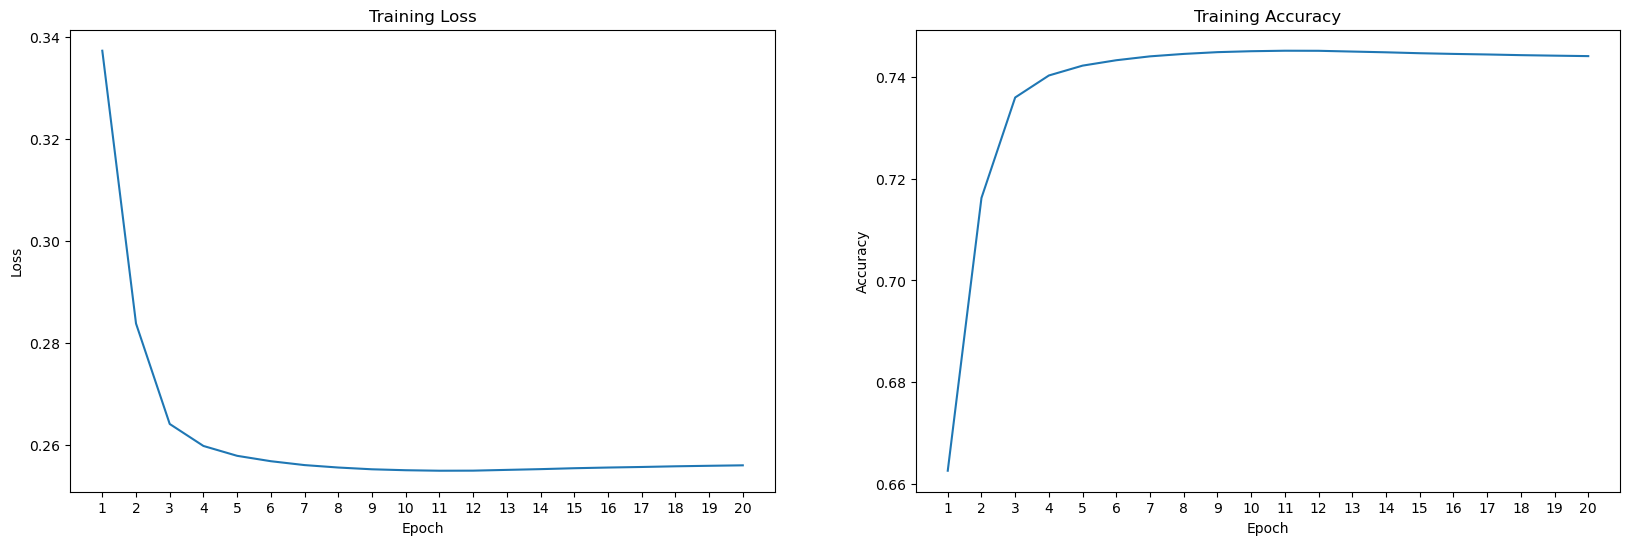

In [15]:
# Plot loss and accuracy
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses)  # Menyesuaikan sumbu x
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(losses) + 1))  # Menyesuaikan nilai pada sumbu x

plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies) + 1), accuracies)  # Menyesuaikan sumbu x
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(accuracies) + 1))  # Menyesuaikan nilai pada sumbu x

plt.show()

In [18]:
# Save weights to a file
def save_weights(weights_hidden2_output, bias_hidden2_output, weights_hidden1_hidden2, bias_hidden1_hidden2, 
                 weights_input_hidden1, bias_input_hidden1, filename):
    with open(filename, 'wb') as f:
        np.savez(f, weights_hidden2_output=weights_hidden2_output, bias_hidden2_output=bias_hidden2_output,
                 weights_hidden1_hidden2=weights_hidden1_hidden2, bias_hidden1_hidden2=bias_hidden1_hidden2,
                 weights_input_hidden1=weights_input_hidden1, bias_input_hidden1=bias_input_hidden1)

save_weights(model.weights_hidden2_output, model.bias_hidden2_output,
             model.weights_hidden1_hidden2, model.bias_hidden1_hidden2,
             model.weights_input_hidden1, model.bias_input_hidden1,
             "6. Bobot_skenario_6.npz")

In [16]:
print(model.output)

[[0.10845789 0.89154211]
 [0.10981034 0.89018966]
 [0.11079189 0.88920811]
 [0.14649355 0.85350645]
 [0.09230068 0.90769932]
 [0.0888932  0.9111068 ]
 [0.13221949 0.86778051]
 [0.33490137 0.66509863]
 [0.30682375 0.69317625]
 [0.28225379 0.71774621]
 [0.15969449 0.84030551]
 [0.14512988 0.85487012]
 [0.17475473 0.82524527]
 [0.42317908 0.57682092]
 [0.41235065 0.58764935]
 [0.23997617 0.76002383]
 [0.16211435 0.83788565]
 [0.31305496 0.68694504]
 [0.45918885 0.54081115]
 [0.20210625 0.79789375]
 [0.10730889 0.89269111]
 [0.12718372 0.87281628]
 [0.14787083 0.85212917]
 [0.10884019 0.89115981]
 [0.2688485  0.7311515 ]
 [0.58694939 0.41305061]
 [0.25909211 0.74090789]
 [0.05216251 0.94783749]
 [0.07615172 0.92384828]
 [0.68056687 0.31943313]
 [0.8386603  0.1613397 ]
 [0.40815294 0.59184706]
 [0.1509465  0.8490535 ]
 [0.09939604 0.90060396]
 [0.11360237 0.88639763]
 [0.08803313 0.91196687]
 [0.09199312 0.90800688]
 [0.12125913 0.87874087]
 [0.26696945 0.73303055]
 [0.39924372 0.60075628]


before argmax 
 [[0.7160838  0.2839162 ]
 [0.7652839  0.2347161 ]
 [0.76308174 0.23691826]
 ...
 [0.05433284 0.94566716]
 [0.05433327 0.94566673]
 [0.05433281 0.94566719]]
after argmax 
 [[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


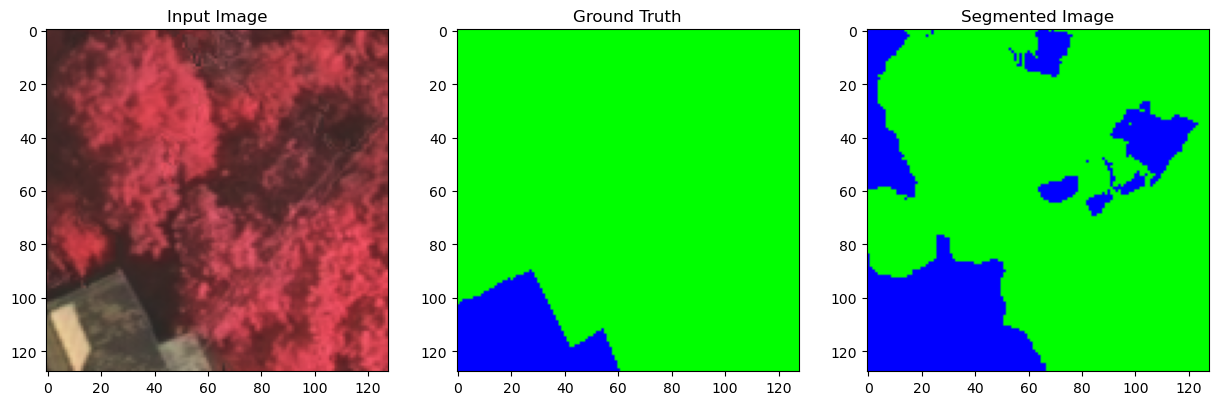

In [17]:
# Define colors for vegetation and non-vegetation
vegetation_color = [0, 255, 0]  # Green
non_vegetation_color = [0, 0, 255]  # Blue

# Visualize segmentation results for one image
indexing = 16
input_image = images_load[indexing]
ground_truth = ground_truths[indexing]
features_get = fe.extract(input_image)

# Preprocess the input image
input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
features = input_image_reshaped.reshape(-1, 3)  # Remove the transpose operation here

# Predict segmentation mask
predicted_mask = model.forward(features)
pred_before = predicted_mask
print('before argmax \n',pred_before)
predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)
pred_after= predicted_mask
print('after argmax \n',pred_after)
# print(len(predicted_mask))
# Create segmented image
segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)

# Assign colors based on predicted mask
segmented_image[predicted_mask == 0] = non_vegetation_color
segmented_image[predicted_mask == 1] = vegetation_color

# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth)
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image)
plt.title('Segmented Image')

plt.show()

In [24]:
print('nilai prediksi \n', pred_before[50:60])
print('hasil argmax \n', pred_after[2][50:60])

nilai prediksi 
 [[ 0.91309717  0.08292262]
 [ 0.9657361   0.03225555]
 [ 0.99289534  0.00696309]
 [ 1.01450834 -0.01145675]
 [ 1.01434747 -0.0074396 ]
 [ 1.00350878  0.00605556]
 [ 0.99560038  0.01536018]
 [ 0.99342313  0.01787501]
 [ 0.99394047  0.01728584]
 [ 0.99504067  0.01600845]]
hasil argmax 
 [0 0 0 0 0 0 0 0 0 0]


Indeks yang ada warna merah
> 2007
> 2011 - 2013

Keperluan BI indeks analisa : 6, 19, 2012, 3192

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth)
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image)
plt.title('Segmented Image')

=-=-=--=-=

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(2, 2, 2)
plt.imshow(features_get)
plt.title('Feature Maps')

plt.subplot(2, 2, 3)
plt.imshow(ground_truth)
plt.title('Ground Truth')

plt.subplot(2, 2, 4)
plt.imshow(segmented_image)
plt.title('Segmented Image')